# import libraries

In [ ]:
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sw
import missingno as msno
from tqdm.notebook import tqdm

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_score, KFold

# import lightgbm as lgb
import xgboost as xgb

# import optuna
# import optuna.visualization as vis

import warnings
warnings.filterwarnings('ignore')

# get data

In [ ]:
raw_train = pd.read_csv('/content/drive/MyDrive/enigma_datathon/train.csv')
raw_test = pd.read_csv('/content/drive/MyDrive/enigma_datathon/test.csv')

In [ ]:
print(raw_train.info())
raw_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Unnamed: 0                    1048575 non-null  int64 
 1   Complaint_ID                  1048575 non-null  int64 
 2   Date received                 1048575 non-null  object
 3   Product                       1048575 non-null  object
 4   Sub-product                   947674 non-null   object
 5   Issue                         1048575 non-null  object
 6   Sub-issue                     766056 non-null   object
 7   Consumer complaint narrative  310809 non-null   object
 8   Company public response       446648 non-null   object
 9   Company                       1048575 non-null  object
 10  State                         1027557 non-null  object
 11  ZIP code                      954841 non-null   object
 12  Tags                          129277 non-n

,Unnamed: 0,Complaint_ID,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Consumer disputed?,Timely response?
0,0,2535701,6/8/2017,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,NaN,NaN,"Caliber Home Loans, Inc.",FL,34744,NaN,NaN,Fax,6/12/2017,Closed with explanation,NaN,Yes
1,1,3314889,7/22/2019,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,On XX/XX/2019 all of my credit and debit cards...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,900XX,NaN,Consent provided,Web,7/22/2019,Closed with explanation,NaN,Yes
2,2,3612478,4/18/2020,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I was made aware of a negative account and inq...,NaN,"EQUIFAX, INC.",CA,945XX,NaN,Consent provided,Web,4/18/2020,Closed with explanation,NaN,Yes
3,3,2069704,8/18/2016,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",TX,77014,NaN,NaN,Phone,8/19/2016,Closed with monetary relief,No,Yes
4,4,3354927,8/27/2019,Debt collection,Auto debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,NaN,NaN,Bridgecrest Acceptance Corporation,PA,19143,Servicemember,Consent not provided,Web,8/27/2019,Closed with explanation,NaN,Yes


# eda

In [ ]:
eda = raw_train.copy()
edat = raw_test.copy()

## missing values matrix

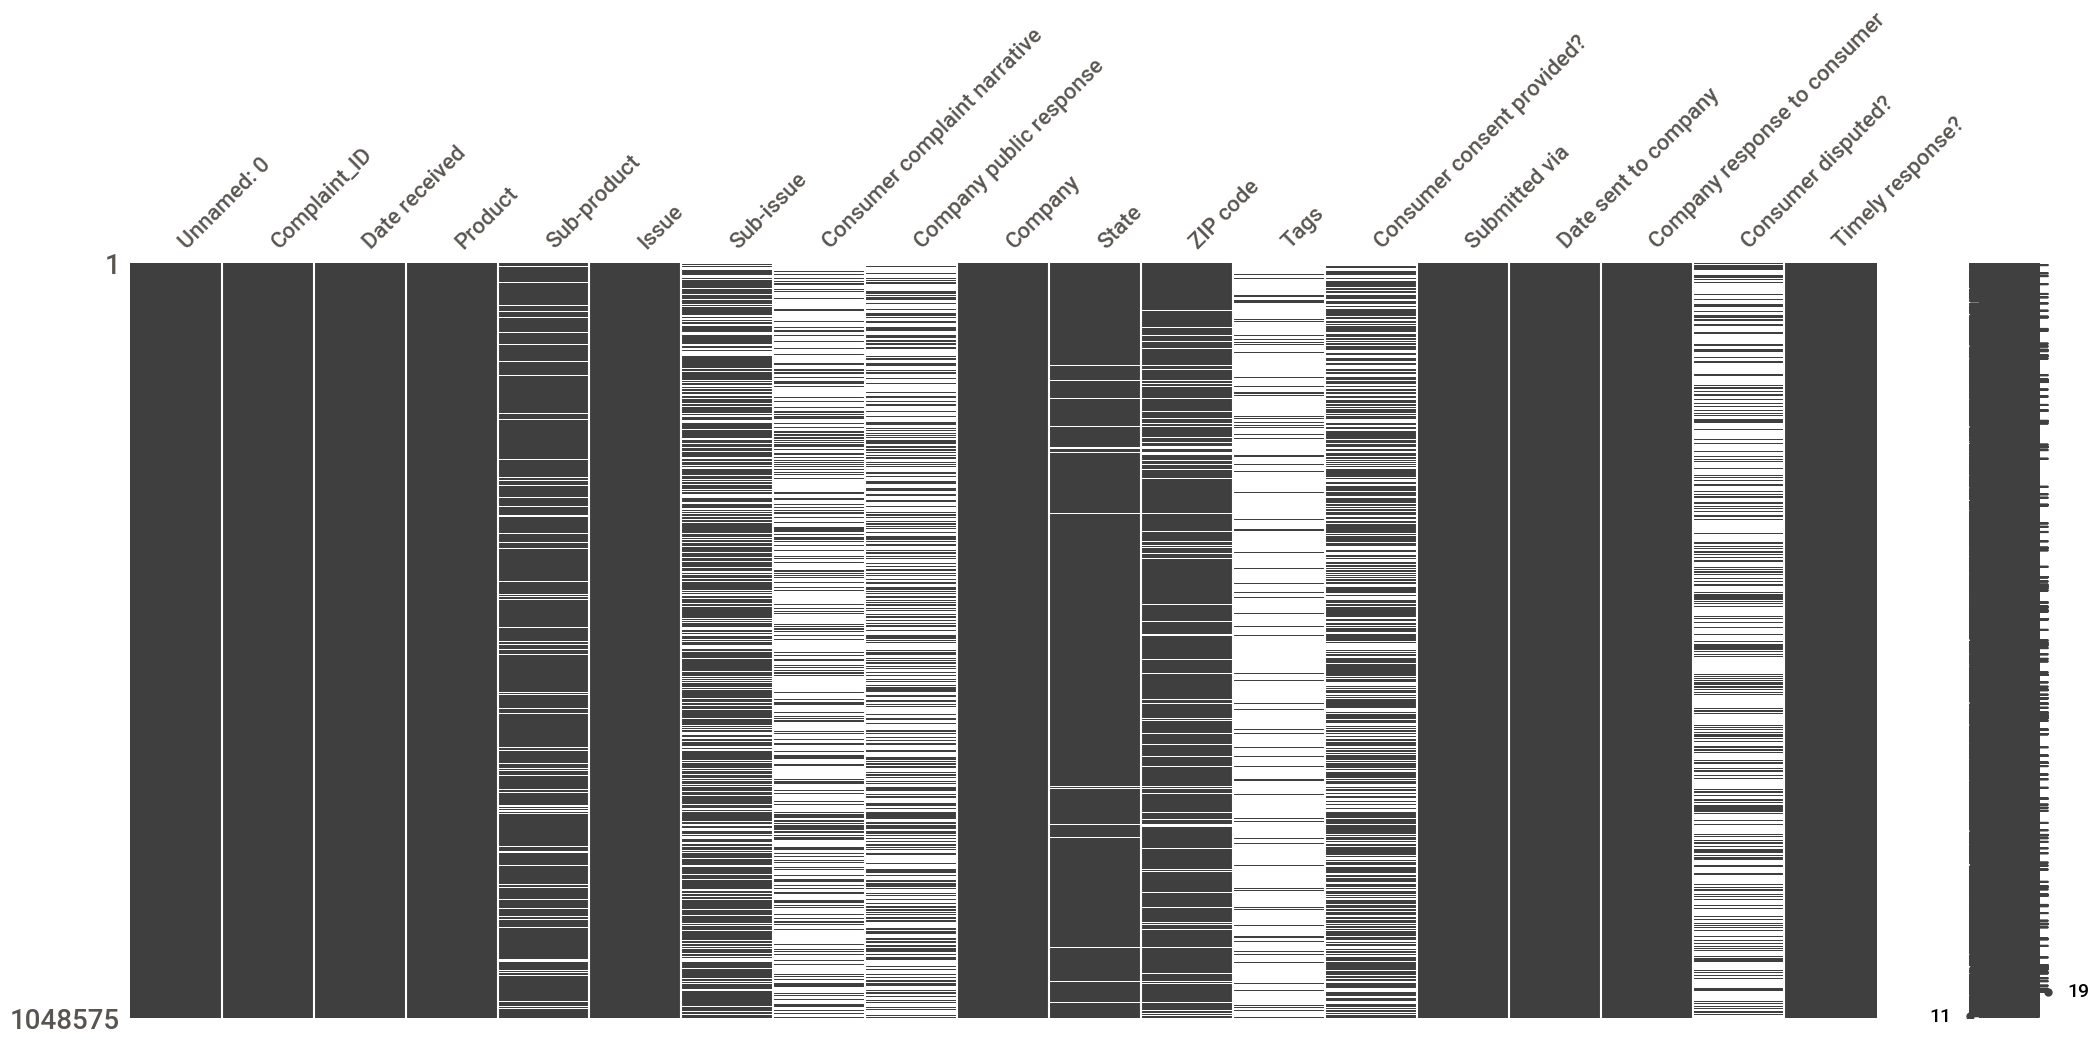

In [ ]:
msno.matrix(eda)

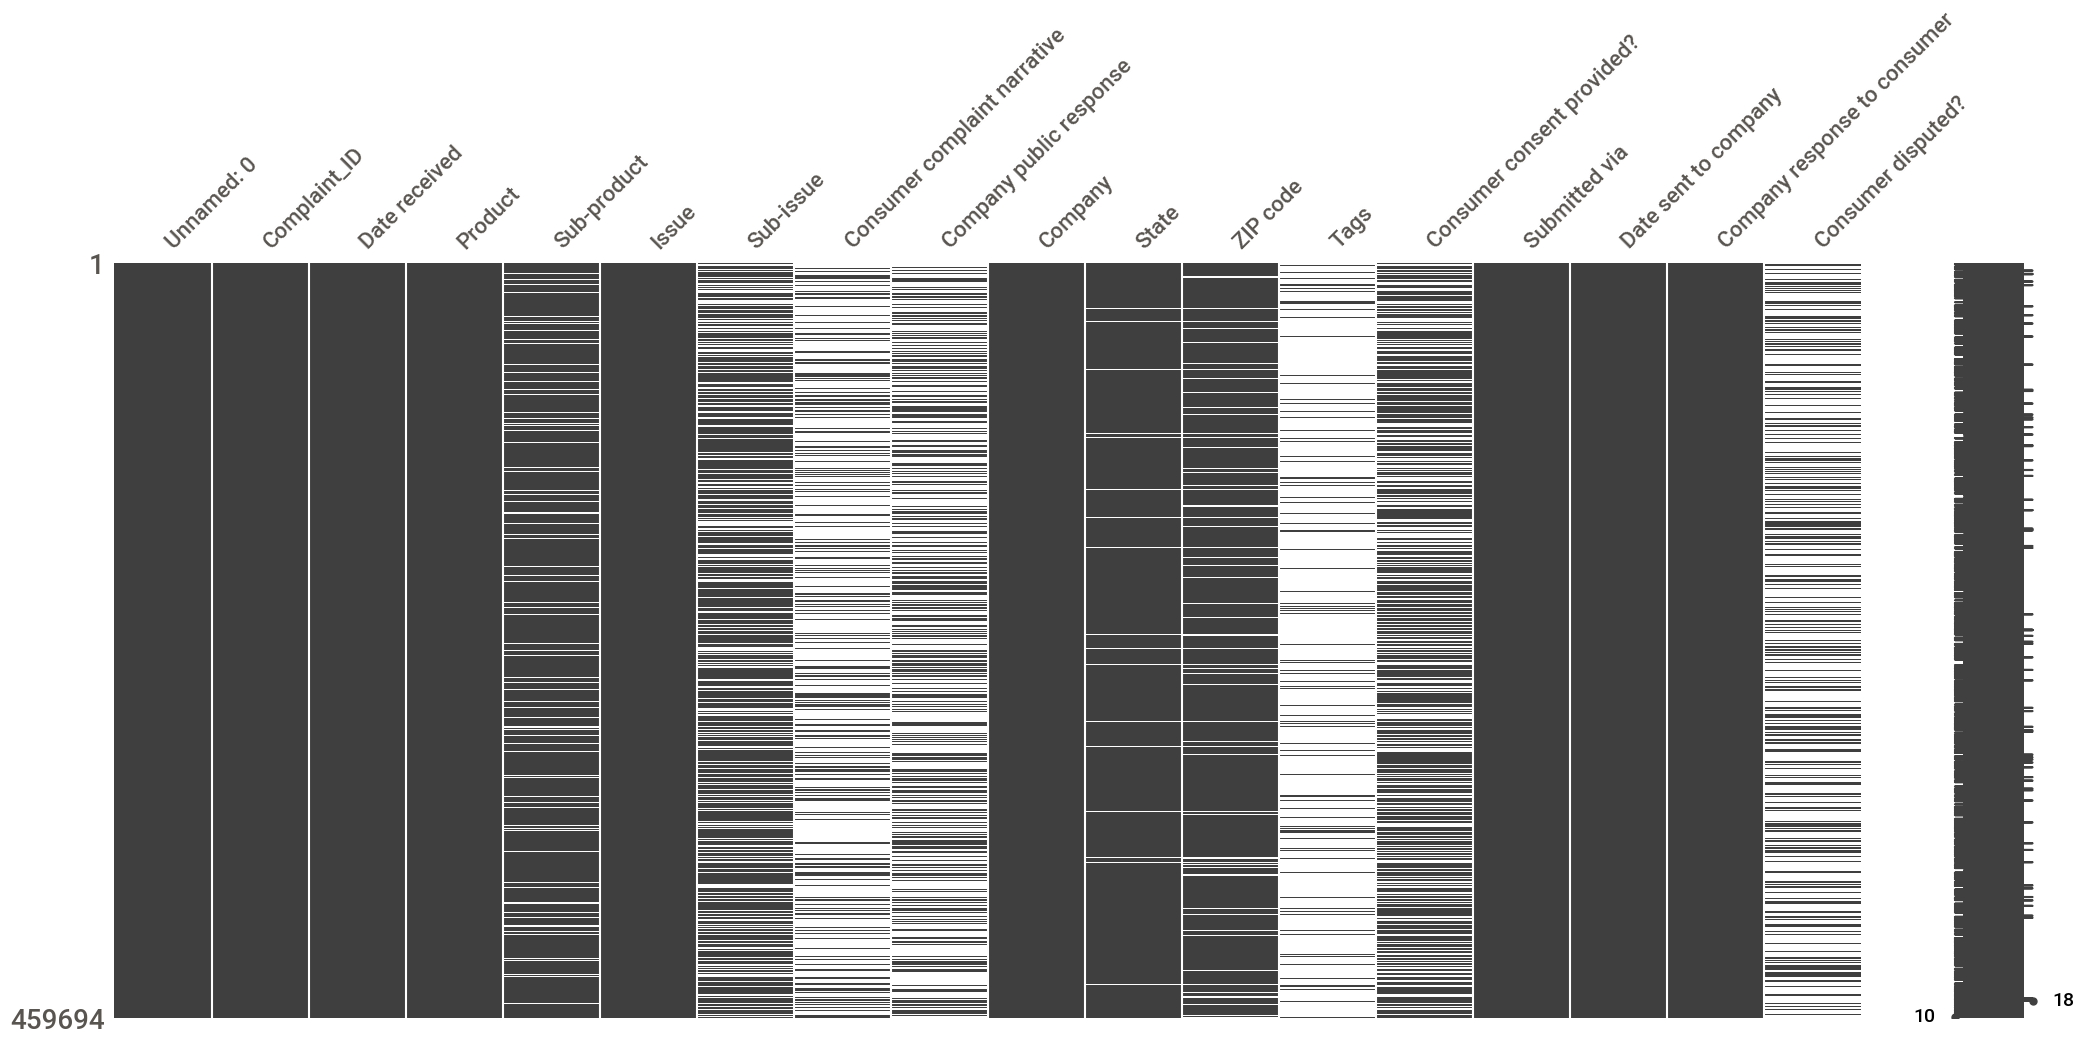

In [ ]:
msno.matrix(edat)

## date

In [ ]:
date_df = eda[['Date sent to company', 'Date received']]
date_dft = edat[['Date sent to company', 'Date received']]

In [ ]:
mask = date_dft['Date sent to company'].

In [ ]:
date_df

,Date sent to company,Date received
0,6/12/2017,6/8/2017
1,7/22/2019,7/22/2019
2,4/18/2020,4/18/2020
3,8/19/2016,8/18/2016
4,8/27/2019,8/27/2019
...,...,...
1048570,8/14/2020,8/13/2020
1048571,11/3/2020,11/3/2020
1048572,9/3/2019,8/30/2019
1048573,12/10/2020,12/10/2020


In [ ]:
pd.to_datetime(date_dft['Date sent to company'])

0        2020-09-10
1        2016-10-04
2        2021-01-21
3        2019-12-10
4        2018-03-26
            ...    
459689   2013-03-07
459690   2017-08-09
459691   2020-09-10
459692   2015-06-17
459693   2020-02-14
Name: Date sent to company, Length: 459694, dtype: datetime64[ns]

In [ ]:
diff.value_counts()

0       766763
1        66892
2        38063
3        30153
4        27928
         ...  
1601         1
578          1
287          1
281          1
511          1
Length: 370, dtype: int64

# preprocess

## drop columns

In [ ]:
train = raw_train.drop(['Unnamed: 0', 'Complaint_ID'], axis=1)
test = raw_test.drop(['Unnamed: 0', 'Complaint_ID'], axis=1)

## date features

In [ ]:
train['Date received'] = pd.to_datetime(train['Date received'], format='%m/%d/%Y')
train['Date sent to company'] = pd.to_datetime(train['Date sent to company'], format='%m/%d/%Y')

In [ ]:
test['Date received'] = pd.to_datetime(test['Date received'])
test['Date sent to company'] = pd.to_datetime(test['Date sent to company'])

In [ ]:
train['date_diff'] = (train['Date sent to company'] - train['Date received']).dt.days
test['date_diff'] = (test['Date sent to company'] - test['Date received']).dt.days

In [ ]:
train = train.drop(['Date received', 'Date sent to company'], axis=1)
test = test.drop(['Date received', 'Date sent to company'], axis=1)

In [ ]:
train.groupby(['date_diff', 'Timely response?']).count()['Product'][-20:]

date_diff  Timely response?
608        Yes                 1
643        No                  1
680        Yes                 1
711        Yes                 1
714        Yes                 1
716        Yes                 1
717        Yes                 1
783        Yes                 1
832        No                  1
833        Yes                 1
838        Yes                 1
855        Yes                 1
993        Yes                 1
999        Yes                 1
1019       Yes                 1
1270       Yes                 1
1601       Yes                 1
1613       Yes                 1
1753       Yes                 1
1754       Yes                 1
Name: Product, dtype: int64

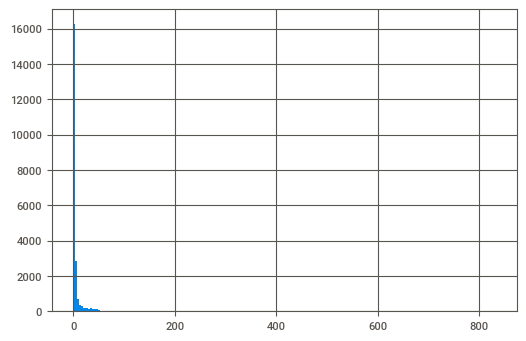

In [ ]:
mask = train['Timely response?'] == 'No'
train.loc[mask, 'date_diff'].hist(bins=200)

In [ ]:
train.head()

,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Company response to consumer,Consumer disputed?,Timely response?,date_diff
0,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,NaN,NaN,"Caliber Home Loans, Inc.",FL,34744,NaN,NaN,Fax,Closed with explanation,NaN,Yes,4
1,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,On XX/XX/2019 all of my credit and debit cards...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,900XX,NaN,Consent provided,Web,Closed with explanation,NaN,Yes,0
2,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I was made aware of a negative account and inq...,NaN,"EQUIFAX, INC.",CA,945XX,NaN,Consent provided,Web,Closed with explanation,NaN,Yes,0
3,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",TX,77014,NaN,NaN,Phone,Closed with monetary relief,No,Yes,1
4,Debt collection,Auto debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,NaN,NaN,Bridgecrest Acceptance Corporation,PA,19143,Servicemember,Consent not provided,Web,Closed with explanation,NaN,Yes,0


## product

In [ ]:
train['Product'].unique().tolist()

['Mortgage',
 'Credit card or prepaid card',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Bank account or service',
 'Debt collection',
 'Credit card',
 'Student loan',
 'Credit reporting',
 'Money transfer, virtual currency, or money service',
 'Money transfers',
 'Checking or savings account',
 'Consumer Loan',
 'Vehicle loan or lease',
 'Payday loan, title loan, or personal loan',
 'Payday loan',
 'Prepaid card',
 'Other financial service',
 'Virtual currency']

In [ ]:
mask = train['Product'] == 'Payday loan'
train.loc[mask, 'Product'] = 'Payday loan, title loan, or personal loan'

In [ ]:
mask = train['Product'].isin(['Credit card', 'Prepaid card'])
train.loc[mask, 'Product'] = 'Credit card or prepaid card'

In [ ]:
mask = train['Product'].isin(['Money transfers', 'Virtual currency'])
train.loc[mask, 'Product'] = 'Money transfer, virtual currency, or money service'

In [ ]:
mask = train['Product'] == 'Credit reporting'
train.loc[mask, 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'

In [ ]:
mask = train['Product'] == 'Other financial service'
train.loc[mask, 'Product'] = 'Bank account or service'

In [ ]:
train['Product'].unique().tolist()

['Mortgage',
 'Credit card or prepaid card',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Bank account or service',
 'Debt collection',
 'Student loan',
 'Money transfer, virtual currency, or money service',
 'Checking or savings account',
 'Consumer Loan',
 'Vehicle loan or lease',
 'Payday loan, title loan, or personal loan']

In [ ]:
train['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    461009
Debt collection                                                                 167263
Mortgage                                                                        153440
Credit card or prepaid card                                                      99787
Checking or savings account                                                      47571
Bank account or service                                                          38940
Student loan                                                                     26920
Money transfer, virtual currency, or money service                               16722
Vehicle loan or lease                                                            13063
Consumer Loan                                                                    12671
Payday loan, title loan, or personal loan                                        11189
Name: Product, dtype: int64

In [ ]:
mask = test['Product'] == 'Payday loan'
test.loc[mask, 'Product'] = 'Payday loan, title loan, or personal loan'

In [ ]:
mask = test['Product'].isin(['Credit card', 'Prepaid card'])
test.loc[mask, 'Product'] = 'Credit card or prepaid card'

In [ ]:
mask = test['Product'].isin(['Money transfers', 'Virtual currency'])
test.loc[mask, 'Product'] = 'Money transfer, virtual currency, or money service'

In [ ]:
mask = test['Product'] == 'Credit reporting'
test.loc[mask, 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'

In [ ]:
mask = test['Product'] == 'Other financial service'
test.loc[mask, 'Product'] = 'Bank account or service'

## deleting columns with missing values

In [ ]:
del_cols = ['Tags', 'Consumer complaint narrative', 'Company public response', 'ZIP code', 'Sub-issue', 'Sub-product']
# del_cols = ['Sub-product']

In [ ]:
train = train.drop(del_cols, axis=1)
test = test.drop(del_cols, axis=1)

In [ ]:
train.head()

,Product,Issue,Company,State,Consumer consent provided?,Submitted via,Company response to consumer,Consumer disputed?,Timely response?,date_diff
0,Mortgage,Struggling to pay mortgage,"Caliber Home Loans, Inc.",FL,NaN,Fax,Closed with explanation,NaN,Yes,4
1,Credit card or prepaid card,Problem with a purchase shown on your statement,WELLS FARGO & COMPANY,CA,Consent provided,Web,Closed with explanation,NaN,Yes,0
2,"Credit reporting, credit repair services, or o...",Incorrect information on your report,"EQUIFAX, INC.",CA,Consent provided,Web,Closed with explanation,NaN,Yes,0
3,Bank account or service,Deposits and withdrawals,"BANK OF AMERICA, NATIONAL ASSOCIATION",TX,NaN,Phone,Closed with monetary relief,No,Yes,1
4,Debt collection,Took or threatened to take negative or legal a...,Bridgecrest Acceptance Corporation,PA,Consent not provided,Web,Closed with explanation,NaN,Yes,0


## company

In [ ]:
train['Company'].value_counts()[:10].index

Index(['EQUIFAX, INC.', 'TRANSUNION INTERMEDIATE HOLDINGS, INC.',
       'Experian Information Solutions Inc.',
       'BANK OF AMERICA, NATIONAL ASSOCIATION', 'WELLS FARGO & COMPANY',
       'JPMORGAN CHASE & CO.', 'CITIBANK, N.A.',
       'CAPITAL ONE FINANCIAL CORPORATION', 'SYNCHRONY FINANCIAL',
       'Navient Solutions, LLC.'],
      dtype='object')

In [ ]:
top_ten_companies = ['EQUIFAX, INC.', 'TRANSUNION INTERMEDIATE HOLDINGS, INC.',
       'Experian Information Solutions Inc.',
       'BANK OF AMERICA, NATIONAL ASSOCIATION', 'WELLS FARGO & COMPANY',
       'JPMORGAN CHASE & CO.', 'CITIBANK, N.A.',
       'CAPITAL ONE FINANCIAL CORPORATION', 'SYNCHRONY FINANCIAL',
       'Navient Solutions, LLC.']

In [ ]:
mask = train['Company'].isin(top_ten_companies)
train.loc[~mask, 'Company'] = 'Other Company'

In [ ]:
mask = test['Company'].isin(top_ten_companies)
test.loc[~mask, 'Company'] = 'Other Company'

## state

In [ ]:
train['State'] = train['State'].fillna(method='bfill')
test['State'] = test['State'].fillna(method='bfill')

In [ ]:
print(train['State'].isna().sum())
print(test['State'].isna().sum())

0
0


## consumer consent provided

In [ ]:
train['Consumer consent provided?'] = train['Consumer consent provided?'].fillna('not available')
test['Consumer consent provided?'] = test['Consumer consent provided?'].fillna('not available')

In [ ]:
print(train['Consumer consent provided?'].isna().sum())
print(test['Consumer consent provided?'].isna().sum())

0
0


 ## consumer disputed

In [ ]:
train['Consumer disputed?'] = train['Consumer disputed?'].fillna('not available')
test['Consumer disputed?'] = test['Consumer disputed?'].fillna('not available')

In [ ]:
print(train['Consumer disputed?'].isna().sum())
print(test['Consumer disputed?'].isna().sum())

0
0


In [ ]:
train.head()

,Product,Issue,Company,State,Consumer consent provided?,Submitted via,Company response to consumer,Consumer disputed?,Timely response?,date_diff
0,Mortgage,Struggling to pay mortgage,Other Company,FL,not available,Fax,Closed with explanation,not available,Yes,4
1,Credit card or prepaid card,Problem with a purchase shown on your statement,WELLS FARGO & COMPANY,CA,Consent provided,Web,Closed with explanation,not available,Yes,0
2,"Credit reporting, credit repair services, or o...",Incorrect information on your report,"EQUIFAX, INC.",CA,Consent provided,Web,Closed with explanation,not available,Yes,0
3,Bank account or service,Deposits and withdrawals,"BANK OF AMERICA, NATIONAL ASSOCIATION",TX,not available,Phone,Closed with monetary relief,No,Yes,1
4,Debt collection,Took or threatened to take negative or legal a...,Other Company,PA,Consent not provided,Web,Closed with explanation,not available,Yes,0


## company response to customer

In [ ]:
train['Company response to consumer'] = train['Company response to consumer'].fillna('Closed with explanation')
test['Company response to consumer'] = test['Company response to consumer'].fillna('Closed with explanation')

In [ ]:
print(train['Company response to consumer'].isna().sum())
print(test['Company response to consumer'].isna().sum())

0
0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Product                       1048575 non-null  object
 1   Issue                         1048575 non-null  object
 2   Company                       1048575 non-null  object
 3   State                         1048575 non-null  object
 4   Consumer consent provided?    1048575 non-null  object
 5   Submitted via                 1048575 non-null  object
 6   Company response to consumer  1048575 non-null  object
 7   Consumer disputed?            1048575 non-null  object
 8   Timely response?              1048575 non-null  object
 9   date_diff                     1048575 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 80.0+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459694 entries, 0 to 459693
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Product                       459694 non-null  object
 1   Issue                         459694 non-null  object
 2   Company                       459694 non-null  object
 3   State                         459694 non-null  object
 4   Consumer consent provided?    459694 non-null  object
 5   Submitted via                 459694 non-null  object
 6   Company response to consumer  459694 non-null  object
 7   Consumer disputed?            459694 non-null  object
 8   date_diff                     459694 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 31.6+ MB


# transformations

In [ ]:
cat_cols = train.select_dtypes(include='object').columns.tolist()
cat_cols

['Product',
 'Issue',
 'Company',
 'State',
 'Consumer consent provided?',
 'Submitted via',
 'Company response to consumer',
 'Consumer disputed?']

In [ ]:
for c in tqdm(cat_cols):
    le = LabelEncoder()

    if c == 'Timely response?':
        train[c] = le.fit_transform(train[c].unique().tolist())
    
    else:
        le.fit(list(set(train[c].unique().tolist() + test[c].unique().tolist())))
        train[c] = le.transform(train[c])
        test[c] = le.transform(test[c])

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
le = LabelEncoder()
train['Timely response?'] = le.fit_transform(train['Timely response?'])

In [ ]:
train['date_diff'] = np.log(2 + train['date_diff'])
test['date_diff'] = np.log(2 + test['date_diff'])

In [ ]:
train

,Product,Issue,Company,State,Consumer consent provided?,Submitted via,Company response to consumer,Consumer disputed?,Timely response?,date_diff
0,7,139,7,13,4,1,1,2,1,1.791759
1,3,117,10,8,1,5,1,2,1,0.693147
2,4,75,3,8,1,5,1,2,1,0.693147
3,0,54,0,53,4,2,2,0,1,1.098612
4,5,146,7,46,0,5,1,2,1,0.693147
...,...,...,...,...,...,...,...,...,...,...
1048570,7,148,7,15,4,4,1,2,1,1.098612
1048571,4,75,9,42,3,5,1,2,1,0.693147
1048572,7,11,0,8,4,4,1,2,1,1.791759
1048573,4,75,4,7,1,5,1,2,1,0.693147


In [ ]:
joblib.dump(train, '/content/drive/MyDrive/enigma_datathon/clean_train')
joblib.dump(test, '/content/drive/MyDrive/enigma_datathon/clean_test')

['/content/drive/MyDrive/enigma_datathon/clean_train']

# models

In [ ]:
X = train.drop('Timely response?', axis=1)
y = train['Timely response?']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [ ]:
lr = LogisticRegression()

In [ ]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_preds = lr.predict(X_test)


0.9893641117081516


In [ ]:
score = f1_score(y_test, lr_preds, average='micro')
print(score)

0.9789237775075698


In [ ]:
scores = cross_val_score(lr, X, y, scoring='f1_weighted')
print(scores, scores.mean())

[0.96862313 0.9686233  0.96861853 0.96862561 0.96861851] 0.9686218143568217


In [ ]:
classification_report(y_test, lr_preds)

'              precision    recall  f1-score   support\n\n           0       0.16      0.00      0.00      4401\n           1       0.98      1.00      0.99    205314\n\n    accuracy                           0.98    209715\n   macro avg       0.57      0.50      0.50    209715\nweighted avg       0.96      0.98      0.97    209715\n'

In [ ]:
rfc = RandomForestClassifier(max_depth=7, random_state=1234)

In [ ]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [ ]:
rfc_preds = rfc.predict(X_test)

In [ ]:
score = f1_score(y_test, rfc_preds, average='micro')
print(score)

0.9790334501585485


In [ ]:
final_preds = rfc.predict(test)

In [ ]:
final_preds.shape

(459694,)

In [ ]:
final_preds.sum() / len(final_preds)

0.9999651942379061

In [ ]:
sub_preds = np.where(final_preds == 1, 'Yes', 'No')

In [ ]:
sub_preds

array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype='<U3')

In [ ]:
sub = pd.DataFrame(
    {'Complaint ID': raw_test['Complaint_ID'], 'Timely response?': sub_preds}
)
sub

,Complaint ID,Timely response?
0,3839774,Yes
1,2139831,Yes
2,4084614,Yes
3,3461505,Yes
4,2854433,Yes
...,...,...
459689,342950,Yes
459690,2599961,Yes
459691,3824572,Yes
459692,1418953,Yes


In [ ]:
sub.to_csv('rfc_2.csv', index=False)

In [ ]:
gbc = GradientBoostingClassifier(learning_rate=0.05, n_estimators=250, max_depth=5)

In [ ]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
gbc_preds = gbc.predict(X_test)

In [ ]:
score = f1_score(y_test, gbc_preds, average='binary')
score

NameError: ignored

In [ ]:
final_preds_gbc = gbc.predict(test)
print(final_preds_gbc.shape)
print(final_preds_gbc.sum() / len(final_preds_gbc))
sub_preds_gbc = np.where(final_preds_gbc == 1, 'Yes', 'No')
sub_gbc = pd.DataFrame(
    {'Complaint ID': raw_test['Complaint_ID'], 'Timely response?': sub_preds_gbc}
)
sub_gbc

(459694,)
0.9980356498018247


,Complaint ID,Timely response?
0,3839774,Yes
1,2139831,Yes
2,4084614,Yes
3,3461505,Yes
4,2854433,Yes
...,...,...
459689,342950,Yes
459690,2599961,Yes
459691,3824572,Yes
459692,1418953,Yes


In [ ]:
sub_gbc.to_csv('gbc_1.csv', index=False)